# Import

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import cv2
import math
import copy
import torch
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.fk_module import GraceLitModule
from src.models.components.fk_net import FKNet
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import mse_loss

import pytransform3d
import pytransform3d.camera as pc
from pytransform3d import rotations as pr
import pytransform3d.transformations as pt
from pytransform3d.plot_utils import make_3d_axis, plot_vector

# Helper Functions

In [2]:
torch.set_default_device('cuda')
torch.set_default_dtype(d=torch.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

MAX_METER_VALUE = 1.5
MAX_DEG_VALUE = 44
MAX_RVEC_VALUE = 1.5708

def min_max_scaler(arr, min_val, max_val):
    scaled_arr = 2 * (arr - min_val) / (max_val - min_val) - 1
    return scaled_arr

def vec2homo(rvec,tvec):
    # Convert the rotation vector to a rotation matrix
    rotation_matrix, _ = cv2.Rodrigues(rvec)

    # Homogeneous Coordinates (H = Tbc =T_board2cam)
    T = np.eye(4)
    T[:3,:3] = rotation_matrix
    T[:3,-1] = tvec.flatten()
    
    return T

def preprocess_csv(data_dir, val_size=0.3, seed=75):
    # Read CSV
    df = pd.read_csv(data_dir)

    # Reorganizing DataFrame
    data_df = pd.DataFrame({
        # Input
        'cmd_lnt_t': df['cmd_theta_lower_neck_tilt'].values,
        'cmd_lnp_t': df['cmd_theta_lower_neck_pan'].values,
        'cmd_unt_t': df['cmd_theta_upper_neck_tilt'].values,
        'cmd_et_t': df['cmd_theta_eyes_tilt'].values,
        'cmd_lep_t': df['cmd_theta_left_eye_pan'].values,
        'cmd_rep_t': df['cmd_theta_right_eye_pan'].values,

        # Targets
        'l_rvec_0': df['l_rvec_0'].values,
        'l_rvec_1': df['l_rvec_1'].values,
        'l_rvec_2': df['l_rvec_2'].values,
        'l_tvec_0': df['l_tvec_0'].values,
        'l_tvec_1': df['l_tvec_1'].values,
        'l_tvec_2': df['l_tvec_2'].values,
        'r_rvec_0': df['r_rvec_0'].values,
        'r_rvec_1': df['r_rvec_1'].values,
        'r_rvec_2': df['r_rvec_2'].values,
        'r_tvec_0': df['r_tvec_0'].values,
        'r_tvec_1': df['r_tvec_1'].values,
        'r_tvec_2': df['r_tvec_2'].values,
    })

    # Minmax Feature Scaler
    feature_ranges = {
        'cmd_lnt_t': (-44, 44),
        'cmd_lnp_t': (-44, 44),
        'cmd_unt_t': (-44, 44),
        'cmd_et_t': (-44, 44),
        'cmd_lep_t': (-44, 44),
        'cmd_rep_t': (-44, 44),
        'l_rvec_0': (-1.5708, 1.5708),
        'l_rvec_1': (-1.5708, 1.5708),
        'l_rvec_2': (-1.5708, 1.5708),
        'l_tvec_0': (-1.5, 1.5),  
        'l_tvec_1': (-1.5, 1.5),  
        'l_tvec_2': (-1.5, 1.5),
        'r_rvec_0': (-1.5708, 1.5708),
        'r_rvec_1': (-1.5708, 1.5708),
        'r_rvec_2': (-1.5708, 1.5708),
        'r_tvec_0': (-1.5, 1.5),
        'r_tvec_1': (-1.5, 1.5),  
        'r_tvec_2': (-1.5, 1.5),
    }
    
    # All Dataset
    all_df = data_df.copy()

    # Separation of Training and Validation Set
    train_df, temp_df = train_test_split(data_df, test_size=val_size, random_state=seed)
    val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=seed)

    # Training Set
    X_train = torch.tensor(train_df.iloc[:,:6].values, dtype=torch.float32)
    y_train = torch.tensor(train_df.iloc[:,6:].values, dtype=torch.float32)
    train_dataset = TensorDataset(X_train, y_train)

    # Validation Set
    X_val = torch.tensor(val_df.iloc[:,:6].values, dtype=torch.float32)
    y_val = torch.tensor(val_df.iloc[:,6:].values, dtype=torch.float32)
    val_dataset = TensorDataset(X_val, y_val)

    # Test Set
    X_test = torch.tensor(test_df.iloc[:,:6].values, dtype=torch.float32)
    y_test = torch.tensor(test_df.iloc[:,6:].values, dtype=torch.float32)
    test_dataset = TensorDataset(X_test, y_test)
    
    # Scaled All Set
    scaled_all_df = all_df.copy()
    for col in all_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_all_df[col] = 2 * (all_df[col] - col_min) / (col_max - col_min) - 1
    
    # Scaled Train Set
    scaled_train_df = train_df.copy()
    for col in train_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_train_df[col] = 2 * (train_df[col] - col_min) / (col_max - col_min) - 1
        
    # Scaled Val Set
    scaled_val_df = val_df.copy()
    for col in val_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_val_df[col] = 2 * (val_df[col] - col_min) / (col_max - col_min) - 1
    
    # Scaled Test Set
    scaled_test_df = test_df.copy()
    for col in test_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_test_df[col] = 2 * (test_df[col] - col_min) / (col_max - col_min) - 1

    return all_df, train_df, val_df, test_df, scaled_all_df, scaled_train_df, scaled_val_df, scaled_test_df


# Error Histogram

In [3]:
csv_fn = '/home/jaynieles/dev/grace_dl/logs/sfk/multiruns/2024-10-25_05-08-29/0/tensorboard/version_0/delta_output_analysis.csv'
csv_df = pd.read_csv(csv_fn)

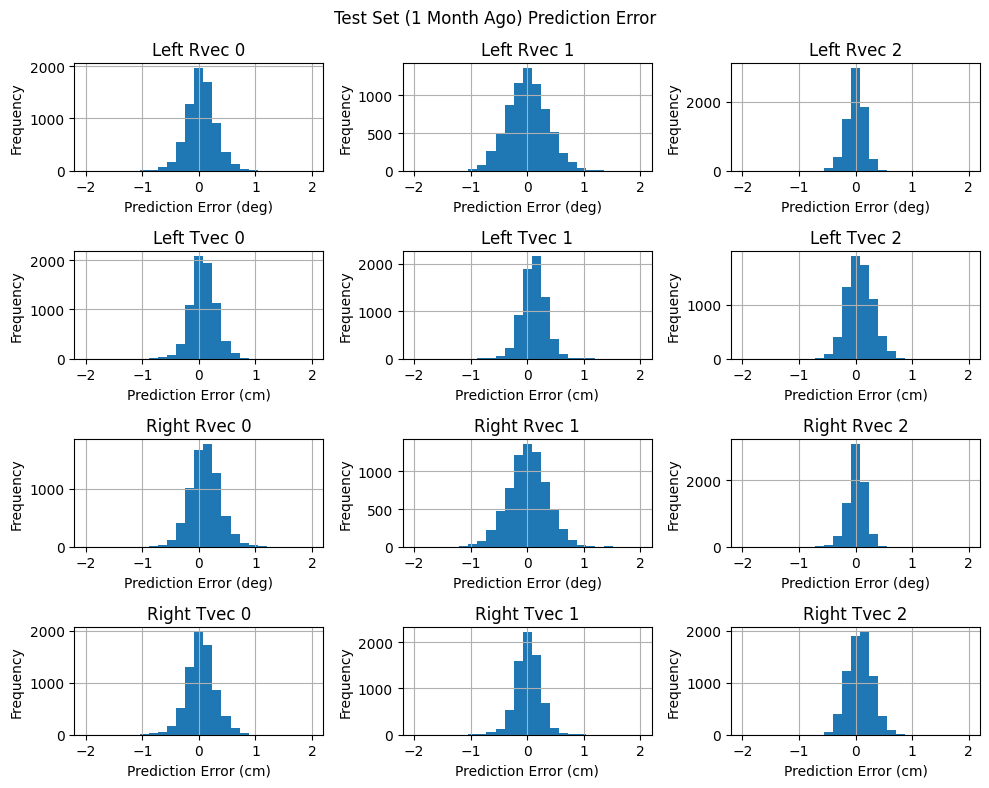

In [4]:
%matplotlib inline

# Initialize
data_list = [
    np.degrees(csv_df['delta_l_rvec_0']),
    np.degrees(csv_df['delta_l_rvec_1']),
    np.degrees(csv_df['delta_l_rvec_2']),
    100*csv_df['delta_l_tvec_0'],
    100*csv_df['delta_l_tvec_1'],
    100*csv_df['delta_l_tvec_2'],
    np.degrees(csv_df['delta_r_rvec_0']),
    np.degrees(csv_df['delta_r_rvec_1']),
    np.degrees(csv_df['delta_r_rvec_2']),
    100*csv_df['delta_r_tvec_0'],
    100*csv_df['delta_r_tvec_1'],
    100*csv_df['delta_r_tvec_2'],
]
hist_label_list = ['Left Rvec 0','Left Rvec 1','Left Rvec 2','Left Tvec 0','Left Tvec 1','Left Tvec 2',
             'Right Rvec 0','Right Rvec 1','Right Rvec 2','Right Tvec 0','Right Tvec 1','Right Tvec 2',]
x_label_list = ['Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',
               'Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',]

# Create a figure and a 2x6 grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(10,8))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Create histograms for each subplot
for i in range(12):
    axs[i].hist(data_list[i], bins=25, range=(-2,2))
    axs[i].set_title(hist_label_list[i])
    axs[i].set_xlabel(x_label_list[i])
    axs[i].set_ylabel('Frequency')
    axs[i].grid()

# Adjust layout to prevent overlap
plt.suptitle('Test Set (1 Month Ago) Prediction Error')
plt.tight_layout()

# Error Table

In [5]:
results_idx = ['r(deg)','p(deg)', 'y(deg)', 'x(cm)','y(cm)', 'z(cm)',]
results_df = pd.DataFrame({'Left Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_0'].values),torch.Tensor(100*csv_df['target_l_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_1'].values),torch.Tensor(100*csv_df['target_l_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_2'].values),torch.Tensor(100*csv_df['target_l_tvec_2'].values)).cpu().item()),
                            ],
                          'Right Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_0'].values),torch.Tensor(100*csv_df['target_r_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_1'].values),torch.Tensor(100*csv_df['target_r_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_2'].values),torch.Tensor(100*csv_df['target_r_tvec_2'].values)).cpu().item()),
                          ],
                          'Left Eye MSE': [
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_0'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_1'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_2'].values))).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_0'].values),torch.Tensor(100*csv_df['target_l_tvec_0'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_1'].values),torch.Tensor(100*csv_df['target_l_tvec_1'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_2'].values),torch.Tensor(100*csv_df['target_l_tvec_2'].values)).cpu().item(),
                            ],
                          'Right Eye MSE': [
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_0'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_1'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_2'].values))).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_0'].values),torch.Tensor(100*csv_df['target_r_tvec_0'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_1'].values),torch.Tensor(100*csv_df['target_r_tvec_1'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_2'].values),torch.Tensor(100*csv_df['target_r_tvec_2'].values)).cpu().item(),
                            ],
                          })
results_df.index = results_idx
results_df

,Left Eye RMSE,Right Eye RMSE,Left Eye MSE,Right Eye MSE
r(deg),0.252848,0.282974,0.063932,0.080074
p(deg),0.349137,0.338347,0.121896,0.114478
y(deg),0.156395,0.151600,0.024459,0.022983
x(cm),0.242796,0.250517,0.058950,0.062759
y(cm),0.244441,0.213950,0.059752,0.045775
z(cm),0.243192,0.226364,0.059142,0.051241


# 3D Plot

In [6]:
# Input
idx = 0

# Left Camera
pred_l_rvec = np.array([csv_df['pred_l_rvec_0'][idx],csv_df['pred_l_rvec_1'][idx],csv_df['pred_l_rvec_2'][idx]])
pred_l_tvec = np.array([csv_df['pred_l_tvec_0'][idx],csv_df['pred_l_tvec_1'][idx],csv_df['pred_l_tvec_2'][idx]])
target_l_rvec =  np.array([csv_df['target_l_rvec_0'][idx],csv_df['target_l_rvec_1'][idx],csv_df['target_l_rvec_2'][idx]])
target_l_tvec = np.array([csv_df['target_l_tvec_0'][idx],csv_df['target_l_tvec_1'][idx],csv_df['target_l_tvec_2'][idx]])
pred_l_homo = vec2homo(pred_l_rvec, pred_l_tvec)
target_l_homo = vec2homo(target_l_rvec, target_l_tvec)
pred_l_homo_inv = np.linalg.inv(pred_l_homo)
target_l_homo_inv = np.linalg.inv(target_l_homo)

# Right Camera
pred_r_rvec = np.array([csv_df['pred_r_rvec_0'][idx],csv_df['pred_r_rvec_1'][idx],csv_df['pred_r_rvec_2'][idx]])
pred_r_tvec = np.array([csv_df['pred_r_tvec_0'][idx],csv_df['pred_r_tvec_1'][idx],csv_df['pred_r_tvec_2'][idx]])
target_r_rvec =  np.array([csv_df['target_r_rvec_0'][idx],csv_df['target_r_rvec_1'][idx],csv_df['target_r_rvec_2'][idx]])
target_r_tvec = np.array([csv_df['target_r_tvec_0'][idx],csv_df['target_r_tvec_1'][idx],csv_df['target_r_tvec_2'][idx]])
pred_r_homo = vec2homo(pred_r_rvec, pred_r_tvec)
target_r_homo = vec2homo(target_r_rvec, target_r_tvec)
pred_r_homo_inv = np.linalg.inv(pred_r_homo)
target_r_homo_inv = np.linalg.inv(target_r_homo)

print('Pred Left Cam:', pred_l_homo)
print('Target Left Cam:', target_l_homo)
print('Pred Right Cam:', pred_r_homo)
print('Target Right Cam:', target_r_homo)

Pred Left Cam: [[ 0.82374376 -0.0076551   0.56691059  0.01882734]
 [-0.08710572  0.9863287   0.13988667  0.22138421]
 [-0.56023103 -0.16461193  0.81181531 -0.06354622]
 [ 0.          0.          0.          1.        ]]
Target Left Cam: [[ 0.82499022 -0.00962712  0.565065    0.01924337]
 [-0.08573448  0.98615075  0.14197286  0.22282383]
 [-0.55860606 -0.16557177  0.81273935 -0.06025553]
 [ 0.          0.          0.          1.        ]]
Pred Right Cam: [[ 0.95827146  0.02220186  0.28499629 -0.02407554]
 [-0.07407842  0.98220859  0.17256497  0.21997601]
 [-0.27609454 -0.18647616  0.94286714 -0.05790186]
 [ 0.          0.          0.          1.        ]]
Target Right Cam: [[ 0.95833242  0.02234404  0.28478014 -0.02681134]
 [-0.07393067  0.98236926  0.17171164  0.22082856]
 [-0.27592252 -0.18561081  0.94308822 -0.05558811]
 [ 0.          0.          0.          1.        ]]


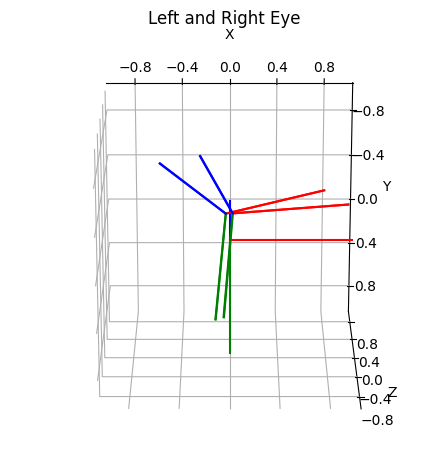

In [7]:
%matplotlib inline

# Plot
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = pr.plot_basis()

# Left Camera
ax = pr.plot_basis(R=pred_l_homo_inv[:3,:3], p=pred_l_homo_inv[:3,3].flatten())
ax = pr.plot_basis(R=target_l_homo_inv[:3,:3], p=target_l_homo_inv[:3,3].flatten())

# Right Camera
ax = pr.plot_basis(R=pred_r_homo_inv[:3,:3], p=pred_r_homo_inv[:3,3].flatten())
ax = pr.plot_basis(R=target_r_homo_inv[:3,:3], p=target_r_homo_inv[:3,3].flatten())

ax.view_init(elev=-70, azim=-90, roll=0)
ax.set_title('Left and Right Eye')
plt.tight_layout()

# Comparison With Other Model 

In [8]:
# Input
csv_fn1 = '/home/jaynieles/dev/grace_dl/logs/sfk/multiruns/2024-10-25_05-08-29/0/tensorboard/version_0/delta_output_analysis.csv'
csv_fn2 = '/home/jaynieles/dev/grace_dl/logs/sfk/multiruns/2024-10-25_04-41-50/3/tensorboard/version_0/delta_output_analysis.csv'

In [9]:
# Read CSV
csv_df1 = pd.read_csv(csv_fn1)
csv_df2 = pd.read_csv(csv_fn2)

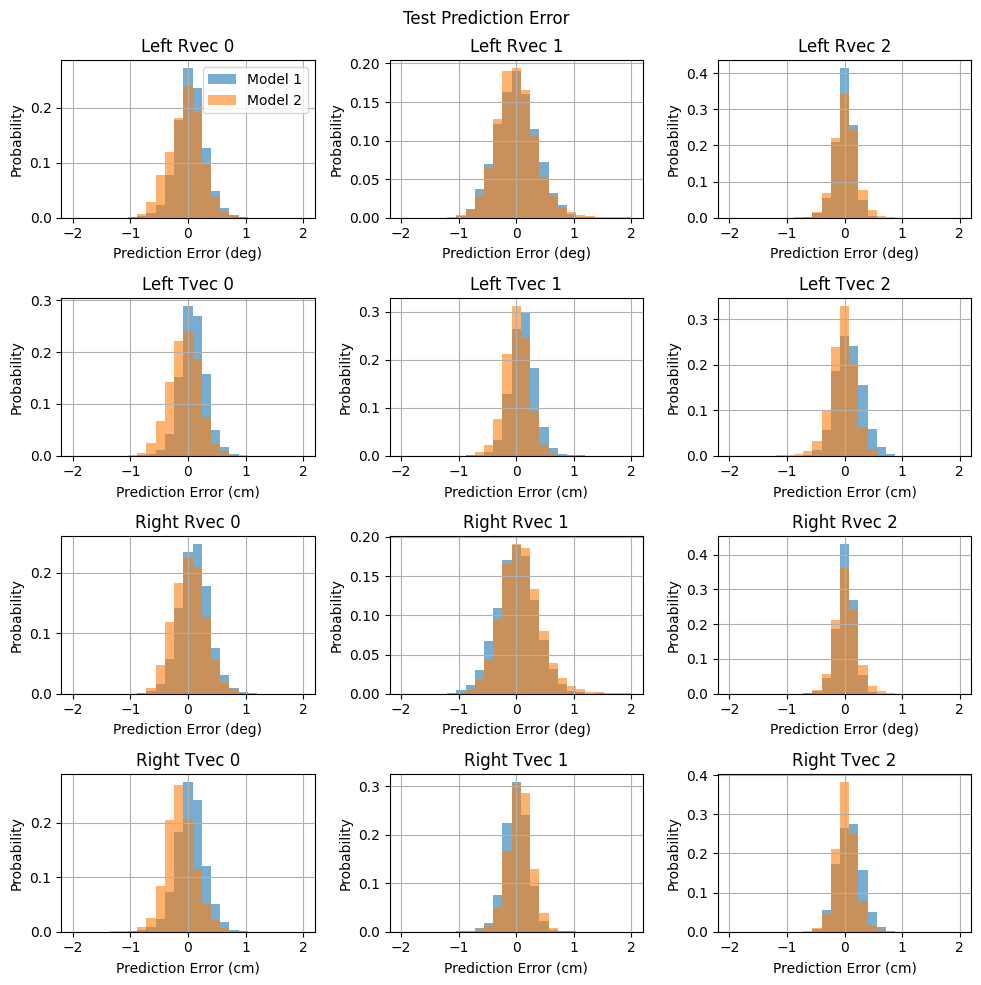

In [10]:
%matplotlib inline

# Initialize
data_list1 = [
    np.degrees(csv_df1['delta_l_rvec_0']),
    np.degrees(csv_df1['delta_l_rvec_1']),
    np.degrees(csv_df1['delta_l_rvec_2']),
    100*csv_df1['delta_l_tvec_0'],
    100*csv_df1['delta_l_tvec_1'],
    100*csv_df1['delta_l_tvec_2'],
    np.degrees(csv_df1['delta_r_rvec_0']),
    np.degrees(csv_df1['delta_r_rvec_1']),
    np.degrees(csv_df1['delta_r_rvec_2']),
    100*csv_df1['delta_r_tvec_0'],
    100*csv_df1['delta_r_tvec_1'],
    100*csv_df1['delta_r_tvec_2'],
]
data_list2 = [
    np.degrees(csv_df2['delta_l_rvec_0']),
    np.degrees(csv_df2['delta_l_rvec_1']),
    np.degrees(csv_df2['delta_l_rvec_2']),
    100*csv_df2['delta_l_tvec_0'],
    100*csv_df2['delta_l_tvec_1'],
    100*csv_df2['delta_l_tvec_2'],
    np.degrees(csv_df2['delta_r_rvec_0']),
    np.degrees(csv_df2['delta_r_rvec_1']),
    np.degrees(csv_df2['delta_r_rvec_2']),
    100*csv_df2['delta_r_tvec_0'],
    100*csv_df2['delta_r_tvec_1'],
    100*csv_df2['delta_r_tvec_2'],
]


hist_label_list = ['Left Rvec 0','Left Rvec 1','Left Rvec 2','Left Tvec 0','Left Tvec 1','Left Tvec 2',
             'Right Rvec 0','Right Rvec 1','Right Rvec 2','Right Tvec 0','Right Tvec 1','Right Tvec 2',]
x_label_list = ['Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',
               'Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',]

# Create a figure and a 2x6 grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(10,10))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Create histograms for each subplot
for i in range(12):
    sns.histplot(data_list1[i], bins=25, ax=axs[i], stat='probability', kde=False, alpha=0.6, binrange=(-2,2), edgecolor=None, label='Model 1')
    sns.histplot(data_list2[i], bins=25, ax=axs[i], stat='probability', kde=False, alpha=0.6, binrange=(-2,2), edgecolor=None, label='Model 2')
    axs[i].set_title(hist_label_list[i])
    axs[i].set_xlabel(x_label_list[i])
    axs[i].set_ylabel('Probability')
    axs[i].grid()
axs[0].legend()

# Adjust layout to prevent overlap
plt.suptitle('Test Prediction Error')
plt.tight_layout()

In [11]:
results_idx = ['r(deg)','p(deg)', 'y(deg)', 'x(cm)','y(cm)', 'z(cm)',]
results_df = pd.DataFrame({'Model 1 Left Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df1['target_l_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df1['target_l_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df1['target_l_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_l_tvec_0'].values),torch.Tensor(100*csv_df1['target_l_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_l_tvec_1'].values),torch.Tensor(100*csv_df1['target_l_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_l_tvec_2'].values),torch.Tensor(100*csv_df1['target_l_tvec_2'].values)).cpu().item()),
                            ],
                          'Model 1 Right Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df1['target_r_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df1['target_r_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df1['target_r_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_r_tvec_0'].values),torch.Tensor(100*csv_df1['target_r_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_r_tvec_1'].values),torch.Tensor(100*csv_df1['target_r_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_r_tvec_2'].values),torch.Tensor(100*csv_df1['target_r_tvec_2'].values)).cpu().item()),
                          ],
                          'Model 2 Left Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df2['target_l_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df2['target_l_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df2['target_l_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_l_tvec_0'].values),torch.Tensor(100*csv_df2['target_l_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_l_tvec_1'].values),torch.Tensor(100*csv_df2['target_l_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_l_tvec_2'].values),torch.Tensor(100*csv_df2['target_l_tvec_2'].values)).cpu().item()),
                            ],
                          'Model 2 Right Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df2['target_r_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df2['target_r_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df2['target_r_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_r_tvec_0'].values),torch.Tensor(100*csv_df2['target_r_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_r_tvec_1'].values),torch.Tensor(100*csv_df2['target_r_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_r_tvec_2'].values),torch.Tensor(100*csv_df2['target_r_tvec_2'].values)).cpu().item()),
                            ],
                          })
results_df.index = results_idx
results_df

,Model 1 Left Eye RMSE,Model 1 Right Eye RMSE,Model 2 Left Eye RMSE,Model 2 Right Eye RMSE
r(deg),0.252848,0.282974,0.282440,0.273884
p(deg),0.349137,0.338347,0.356400,0.371739
y(deg),0.156395,0.151600,0.194340,0.191972
x(cm),0.242796,0.250517,0.268632,0.288392
y(cm),0.244441,0.213950,0.215656,0.217073
z(cm),0.243192,0.226364,0.219794,0.175959


# Load ANN Model

In [12]:
ckpt_path = '/home/jaynieles/dev/grace_dl/logs/sfk/multiruns/2024-10-25_05-08-29/0/checkpoints/epoch_166.ckpt'

In [13]:
model = GraceLitModule.load_from_checkpoint(ckpt_path)

/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


# Load Another Test Dataset

In [14]:
dataset_fn = "/home/jaynieles/dev/grace_dl/data/thesis/241005_075m_test_grace_dataset_1000.csv"
all_df,train_df,val_df,test_df,scaled_all_df,scaled_train_df,scaled_val_df,scaled_test_df = preprocess_csv(dataset_fn)

In [15]:
# Tensor Set

X_all = torch.tensor(scaled_all_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_all = torch.tensor(scaled_all_df.iloc[:,6:].values, dtype=torch.float32, device=device)
X_train = torch.tensor(scaled_train_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_train = torch.tensor(scaled_train_df.iloc[:,6:].values, dtype=torch.float32, device=device)
X_val = torch.tensor(scaled_val_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_val = torch.tensor(scaled_val_df.iloc[:,6:].values, dtype=torch.float32, device=device)
X_test = torch.tensor(scaled_test_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_test = torch.tensor(scaled_test_df.iloc[:,6:].values, dtype=torch.float32, device=device)

In [16]:
# Model Evaluation
model.eval()
# Output of DNN
with torch.no_grad():
    preds = model(X_all)

In [17]:
# Organizing Results for analysis
inputs_arr = X_all.detach().cpu().numpy()
preds_arr = preds.detach().cpu().numpy()
targets_arr = y_all.detach().cpu().numpy()

# Reorganizing DataFrame
data_df = pd.DataFrame({
    'cmd_lnt_t': MAX_DEG_VALUE*inputs_arr[:,0],
    'cmd_lnp_t': MAX_DEG_VALUE*inputs_arr[:,1],
    'cmd_unt_t': MAX_DEG_VALUE*inputs_arr[:,2],
    'cmd_et_t': MAX_DEG_VALUE*inputs_arr[:,3],
    'cmd_lep_t': MAX_DEG_VALUE*inputs_arr[:,4],
    'cmd_rep_t': MAX_DEG_VALUE*inputs_arr[:,5],

    'target_l_rvec_0': MAX_RVEC_VALUE*targets_arr[:,0],
    'target_l_rvec_1': MAX_RVEC_VALUE*targets_arr[:,1],
    'target_l_rvec_2': MAX_RVEC_VALUE*targets_arr[:,2],
    'target_l_tvec_0': MAX_METER_VALUE*targets_arr[:,3],
    'target_l_tvec_1': MAX_METER_VALUE*targets_arr[:,4],
    'target_l_tvec_2': MAX_METER_VALUE*targets_arr[:,5],
    'target_r_rvec_0': MAX_RVEC_VALUE*targets_arr[:,6],
    'target_r_rvec_1': MAX_RVEC_VALUE*targets_arr[:,7],
    'target_r_rvec_2': MAX_RVEC_VALUE*targets_arr[:,8],
    'target_r_tvec_0': MAX_METER_VALUE*targets_arr[:,9],
    'target_r_tvec_1': MAX_METER_VALUE*targets_arr[:,10],
    'target_r_tvec_2': MAX_METER_VALUE*targets_arr[:,11],

    'pred_l_rvec_0': MAX_RVEC_VALUE*preds_arr[:,0],
    'pred_l_rvec_1': MAX_RVEC_VALUE*preds_arr[:,1],
    'pred_l_rvec_2': MAX_RVEC_VALUE*preds_arr[:,2],
    'pred_l_tvec_0': MAX_METER_VALUE*preds_arr[:,3],
    'pred_l_tvec_1': MAX_METER_VALUE*preds_arr[:,4],
    'pred_l_tvec_2': MAX_METER_VALUE*preds_arr[:,5],
    'pred_r_rvec_0': MAX_RVEC_VALUE*preds_arr[:,6],
    'pred_r_rvec_1': MAX_RVEC_VALUE*preds_arr[:,7],
    'pred_r_rvec_2': MAX_RVEC_VALUE*preds_arr[:,8],
    'pred_r_tvec_0': MAX_METER_VALUE*preds_arr[:,9],
    'pred_r_tvec_1': MAX_METER_VALUE*preds_arr[:,10],
    'pred_r_tvec_2': MAX_METER_VALUE*preds_arr[:,11],
})

# Delta Analysis
data_df['delta_l_rvec_0'] = data_df['target_l_rvec_0'].values - data_df['pred_l_rvec_0'].values
data_df['delta_l_rvec_1'] = data_df['target_l_rvec_1'].values - data_df['pred_l_rvec_1'].values
data_df['delta_l_rvec_2'] = data_df['target_l_rvec_2'].values - data_df['pred_l_rvec_2'].values
data_df['delta_l_tvec_0'] = data_df['target_l_tvec_0'].values - data_df['pred_l_tvec_0'].values
data_df['delta_l_tvec_1'] = data_df['target_l_tvec_1'].values - data_df['pred_l_tvec_1'].values
data_df['delta_l_tvec_2'] = data_df['target_l_tvec_2'].values - data_df['pred_l_tvec_2'].values
data_df['delta_r_rvec_0'] = data_df['target_r_rvec_0'].values - data_df['pred_r_rvec_0'].values
data_df['delta_r_rvec_1'] = data_df['target_r_rvec_1'].values - data_df['pred_r_rvec_1'].values
data_df['delta_r_rvec_2'] = data_df['target_r_rvec_2'].values - data_df['pred_r_rvec_2'].values
data_df['delta_r_tvec_0'] = data_df['target_r_tvec_0'].values - data_df['pred_r_tvec_0'].values
data_df['delta_r_tvec_1'] = data_df['target_r_tvec_1'].values - data_df['pred_r_tvec_1'].values
data_df['delta_r_tvec_2'] = data_df['target_r_tvec_2'].values - data_df['pred_r_tvec_2'].values

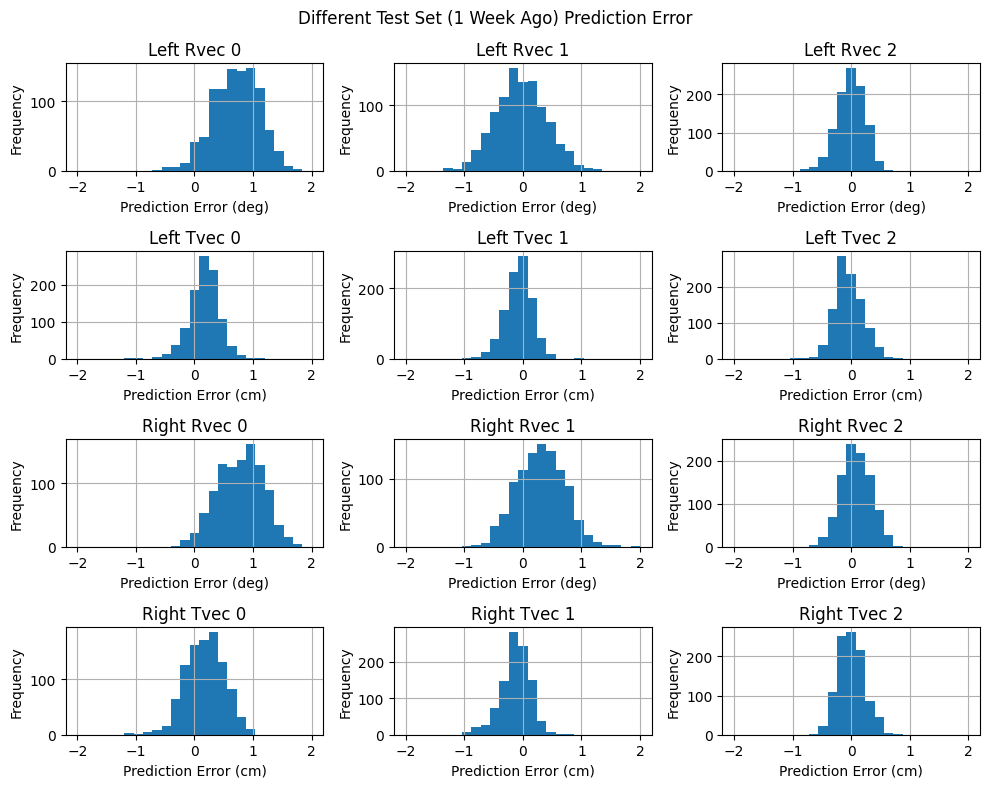

In [18]:
%matplotlib inline

# Initialize
data_list = [
    np.degrees(data_df['delta_l_rvec_0']),
    np.degrees(data_df['delta_l_rvec_1']),
    np.degrees(data_df['delta_l_rvec_2']),
    100*data_df['delta_l_tvec_0'],
    100*data_df['delta_l_tvec_1'],
    100*data_df['delta_l_tvec_2'],
    np.degrees(data_df['delta_r_rvec_0']),
    np.degrees(data_df['delta_r_rvec_1']),
    np.degrees(data_df['delta_r_rvec_2']),
    100*data_df['delta_r_tvec_0'],
    100*data_df['delta_r_tvec_1'],
    100*data_df['delta_r_tvec_2'],
]
hist_label_list = ['Left Rvec 0','Left Rvec 1','Left Rvec 2','Left Tvec 0','Left Tvec 1','Left Tvec 2',
             'Right Rvec 0','Right Rvec 1','Right Rvec 2','Right Tvec 0','Right Tvec 1','Right Tvec 2',]
x_label_list = ['Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',
               'Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',]

# Create a figure and a 2x6 grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(10,8))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Create histograms for each subplot
for i in range(12):
    axs[i].hist(data_list[i], bins=25, range=(-2,2))
    axs[i].set_title(hist_label_list[i])
    axs[i].set_xlabel(x_label_list[i])
    axs[i].set_ylabel('Frequency')
    axs[i].grid()

# Adjust layout to prevent overlap
plt.suptitle('Different Test Set (1 Week Ago) Prediction Error')
plt.tight_layout()

In [19]:
csv_df = data_df.copy()
results_idx = ['r(deg)','p(deg)', 'y(deg)', 'x(cm)','y(cm)', 'z(cm)',]
results_df = pd.DataFrame({'Left Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_0'].values),torch.Tensor(100*csv_df['target_l_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_1'].values),torch.Tensor(100*csv_df['target_l_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_2'].values),torch.Tensor(100*csv_df['target_l_tvec_2'].values)).cpu().item()),
                            ],
                          'Right Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_0'].values),torch.Tensor(100*csv_df['target_r_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_1'].values),torch.Tensor(100*csv_df['target_r_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_2'].values),torch.Tensor(100*csv_df['target_r_tvec_2'].values)).cpu().item()),
                          ],
                          'Left Eye MSE': [
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_0'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_1'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_2'].values))).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_0'].values),torch.Tensor(100*csv_df['target_l_tvec_0'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_1'].values),torch.Tensor(100*csv_df['target_l_tvec_1'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_2'].values),torch.Tensor(100*csv_df['target_l_tvec_2'].values)).cpu().item(),
                            ],
                          'Right Eye MSE': [
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_0'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_1'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_2'].values))).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_0'].values),torch.Tensor(100*csv_df['target_r_tvec_0'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_1'].values),torch.Tensor(100*csv_df['target_r_tvec_1'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_2'].values),torch.Tensor(100*csv_df['target_r_tvec_2'].values)).cpu().item(),
                            ],
                          })
results_df.index = results_idx
results_df

,Left Eye RMSE,Right Eye RMSE,Left Eye MSE,Right Eye MSE
r(deg),0.814848,0.872169,0.663978,0.760678
p(deg),0.430687,0.503746,0.185492,0.253760
y(deg),0.230405,0.266250,0.053086,0.070889
x(cm),0.301886,0.376008,0.091135,0.141382
y(cm),0.239610,0.285565,0.057413,0.081547
z(cm),0.237292,0.220768,0.056307,0.048738


# Test Comparison with Other Model

In [20]:
ckpt_path1 = '/home/jaynieles/dev/grace_dl/logs/sfk/multiruns/2024-10-25_05-08-29/0/checkpoints/epoch_166.ckpt'
ckpt_path2 = '/home/jaynieles/dev/grace_dl/logs/sfk/multiruns/2024-10-25_04-41-50/3/checkpoints/epoch_226.ckpt'
dataset_fn = "/home/jaynieles/dev/grace_dl/data/thesis/241005_075m_test_grace_dataset_1000.csv"

In [21]:
# Load Model and Dataset
model1 = GraceLitModule.load_from_checkpoint(ckpt_path1)
model2 = GraceLitModule.load_from_checkpoint(ckpt_path2)
all_df,train_df,val_df,test_df,scaled_all_df,scaled_train_df,scaled_val_df,scaled_test_df = preprocess_csv(dataset_fn)

# Tensor Set
X_all = torch.tensor(scaled_all_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_all = torch.tensor(scaled_all_df.iloc[:,6:].values, dtype=torch.float32, device=device)
X_train = torch.tensor(scaled_train_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_train = torch.tensor(scaled_train_df.iloc[:,6:].values, dtype=torch.float32, device=device)
X_val = torch.tensor(scaled_val_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_val = torch.tensor(scaled_val_df.iloc[:,6:].values, dtype=torch.float32, device=device)
X_test = torch.tensor(scaled_test_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_test = torch.tensor(scaled_test_df.iloc[:,6:].values, dtype=torch.float32, device=device)

/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [22]:
# Model 1 Evaluation
model1.eval()
with torch.no_grad():
    preds1 = model1(X_all)
    
# Organizing Results for analysis
inputs_arr = X_all.detach().cpu().numpy()
preds_arr1 = preds1.detach().cpu().numpy()
targets_arr = y_all.detach().cpu().numpy()

# Reorganizing DataFrame
data_df1 = pd.DataFrame({
    'cmd_lnt_t': MAX_DEG_VALUE*inputs_arr[:,0],
    'cmd_lnp_t': MAX_DEG_VALUE*inputs_arr[:,1],
    'cmd_unt_t': MAX_DEG_VALUE*inputs_arr[:,2],
    'cmd_et_t': MAX_DEG_VALUE*inputs_arr[:,3],
    'cmd_lep_t': MAX_DEG_VALUE*inputs_arr[:,4],
    'cmd_rep_t': MAX_DEG_VALUE*inputs_arr[:,5],

    'target_l_rvec_0': MAX_RVEC_VALUE*targets_arr[:,0],
    'target_l_rvec_1': MAX_RVEC_VALUE*targets_arr[:,1],
    'target_l_rvec_2': MAX_RVEC_VALUE*targets_arr[:,2],
    'target_l_tvec_0': MAX_METER_VALUE*targets_arr[:,3],
    'target_l_tvec_1': MAX_METER_VALUE*targets_arr[:,4],
    'target_l_tvec_2': MAX_METER_VALUE*targets_arr[:,5],
    'target_r_rvec_0': MAX_RVEC_VALUE*targets_arr[:,6],
    'target_r_rvec_1': MAX_RVEC_VALUE*targets_arr[:,7],
    'target_r_rvec_2': MAX_RVEC_VALUE*targets_arr[:,8],
    'target_r_tvec_0': MAX_METER_VALUE*targets_arr[:,9],
    'target_r_tvec_1': MAX_METER_VALUE*targets_arr[:,10],
    'target_r_tvec_2': MAX_METER_VALUE*targets_arr[:,11],

    'pred_l_rvec_0': MAX_RVEC_VALUE*preds_arr1[:,0],
    'pred_l_rvec_1': MAX_RVEC_VALUE*preds_arr1[:,1],
    'pred_l_rvec_2': MAX_RVEC_VALUE*preds_arr1[:,2],
    'pred_l_tvec_0': MAX_METER_VALUE*preds_arr1[:,3],
    'pred_l_tvec_1': MAX_METER_VALUE*preds_arr1[:,4],
    'pred_l_tvec_2': MAX_METER_VALUE*preds_arr1[:,5],
    'pred_r_rvec_0': MAX_RVEC_VALUE*preds_arr1[:,6],
    'pred_r_rvec_1': MAX_RVEC_VALUE*preds_arr1[:,7],
    'pred_r_rvec_2': MAX_RVEC_VALUE*preds_arr1[:,8],
    'pred_r_tvec_0': MAX_METER_VALUE*preds_arr1[:,9],
    'pred_r_tvec_1': MAX_METER_VALUE*preds_arr1[:,10],
    'pred_r_tvec_2': MAX_METER_VALUE*preds_arr1[:,11],
})

# Delta Analysis
data_df1['delta_l_rvec_0'] = data_df1['target_l_rvec_0'].values - data_df1['pred_l_rvec_0'].values
data_df1['delta_l_rvec_1'] = data_df1['target_l_rvec_1'].values - data_df1['pred_l_rvec_1'].values
data_df1['delta_l_rvec_2'] = data_df1['target_l_rvec_2'].values - data_df1['pred_l_rvec_2'].values
data_df1['delta_l_tvec_0'] = data_df1['target_l_tvec_0'].values - data_df1['pred_l_tvec_0'].values
data_df1['delta_l_tvec_1'] = data_df1['target_l_tvec_1'].values - data_df1['pred_l_tvec_1'].values
data_df1['delta_l_tvec_2'] = data_df1['target_l_tvec_2'].values - data_df1['pred_l_tvec_2'].values
data_df1['delta_r_rvec_0'] = data_df1['target_r_rvec_0'].values - data_df1['pred_r_rvec_0'].values
data_df1['delta_r_rvec_1'] = data_df1['target_r_rvec_1'].values - data_df1['pred_r_rvec_1'].values
data_df1['delta_r_rvec_2'] = data_df1['target_r_rvec_2'].values - data_df1['pred_r_rvec_2'].values
data_df1['delta_r_tvec_0'] = data_df1['target_r_tvec_0'].values - data_df1['pred_r_tvec_0'].values
data_df1['delta_r_tvec_1'] = data_df1['target_r_tvec_1'].values - data_df1['pred_r_tvec_1'].values
data_df1['delta_r_tvec_2'] = data_df1['target_r_tvec_2'].values - data_df1['pred_r_tvec_2'].values

In [23]:
# Model 2 Evaluation
model2.eval()
with torch.no_grad():
    preds2 = model2(X_all)
    
# Organizing Results for analysis
inputs_arr = X_all.detach().cpu().numpy()
preds_arr2 = preds2.detach().cpu().numpy()
targets_arr = y_all.detach().cpu().numpy()

# Reorganizing DataFrame
data_df2 = pd.DataFrame({
    'cmd_lnt_t': MAX_DEG_VALUE*inputs_arr[:,0],
    'cmd_lnp_t': MAX_DEG_VALUE*inputs_arr[:,1],
    'cmd_unt_t': MAX_DEG_VALUE*inputs_arr[:,2],
    'cmd_et_t': MAX_DEG_VALUE*inputs_arr[:,3],
    'cmd_lep_t': MAX_DEG_VALUE*inputs_arr[:,4],
    'cmd_rep_t': MAX_DEG_VALUE*inputs_arr[:,5],

    'target_l_rvec_0': MAX_RVEC_VALUE*targets_arr[:,0],
    'target_l_rvec_1': MAX_RVEC_VALUE*targets_arr[:,1],
    'target_l_rvec_2': MAX_RVEC_VALUE*targets_arr[:,2],
    'target_l_tvec_0': MAX_METER_VALUE*targets_arr[:,3],
    'target_l_tvec_1': MAX_METER_VALUE*targets_arr[:,4],
    'target_l_tvec_2': MAX_METER_VALUE*targets_arr[:,5],
    'target_r_rvec_0': MAX_RVEC_VALUE*targets_arr[:,6],
    'target_r_rvec_1': MAX_RVEC_VALUE*targets_arr[:,7],
    'target_r_rvec_2': MAX_RVEC_VALUE*targets_arr[:,8],
    'target_r_tvec_0': MAX_METER_VALUE*targets_arr[:,9],
    'target_r_tvec_1': MAX_METER_VALUE*targets_arr[:,10],
    'target_r_tvec_2': MAX_METER_VALUE*targets_arr[:,11],

    'pred_l_rvec_0': MAX_RVEC_VALUE*preds_arr2[:,0],
    'pred_l_rvec_1': MAX_RVEC_VALUE*preds_arr2[:,1],
    'pred_l_rvec_2': MAX_RVEC_VALUE*preds_arr2[:,2],
    'pred_l_tvec_0': MAX_METER_VALUE*preds_arr2[:,3],
    'pred_l_tvec_1': MAX_METER_VALUE*preds_arr2[:,4],
    'pred_l_tvec_2': MAX_METER_VALUE*preds_arr2[:,5],
    'pred_r_rvec_0': MAX_RVEC_VALUE*preds_arr2[:,6],
    'pred_r_rvec_1': MAX_RVEC_VALUE*preds_arr2[:,7],
    'pred_r_rvec_2': MAX_RVEC_VALUE*preds_arr2[:,8],
    'pred_r_tvec_0': MAX_METER_VALUE*preds_arr2[:,9],
    'pred_r_tvec_1': MAX_METER_VALUE*preds_arr2[:,10],
    'pred_r_tvec_2': MAX_METER_VALUE*preds_arr2[:,11],
})

# Delta Analysis
data_df2['delta_l_rvec_0'] = data_df2['target_l_rvec_0'].values - data_df2['pred_l_rvec_0'].values
data_df2['delta_l_rvec_1'] = data_df2['target_l_rvec_1'].values - data_df2['pred_l_rvec_1'].values
data_df2['delta_l_rvec_2'] = data_df2['target_l_rvec_2'].values - data_df2['pred_l_rvec_2'].values
data_df2['delta_l_tvec_0'] = data_df2['target_l_tvec_0'].values - data_df2['pred_l_tvec_0'].values
data_df2['delta_l_tvec_1'] = data_df2['target_l_tvec_1'].values - data_df2['pred_l_tvec_1'].values
data_df2['delta_l_tvec_2'] = data_df2['target_l_tvec_2'].values - data_df2['pred_l_tvec_2'].values
data_df2['delta_r_rvec_0'] = data_df2['target_r_rvec_0'].values - data_df2['pred_r_rvec_0'].values
data_df2['delta_r_rvec_1'] = data_df2['target_r_rvec_1'].values - data_df2['pred_r_rvec_1'].values
data_df2['delta_r_rvec_2'] = data_df2['target_r_rvec_2'].values - data_df2['pred_r_rvec_2'].values
data_df2['delta_r_tvec_0'] = data_df2['target_r_tvec_0'].values - data_df2['pred_r_tvec_0'].values
data_df2['delta_r_tvec_1'] = data_df2['target_r_tvec_1'].values - data_df2['pred_r_tvec_1'].values
data_df2['delta_r_tvec_2'] = data_df2['target_r_tvec_2'].values - data_df2['pred_r_tvec_2'].values

In [24]:
csv_df1 = data_df1.copy()
csv_df2 = data_df2.copy()

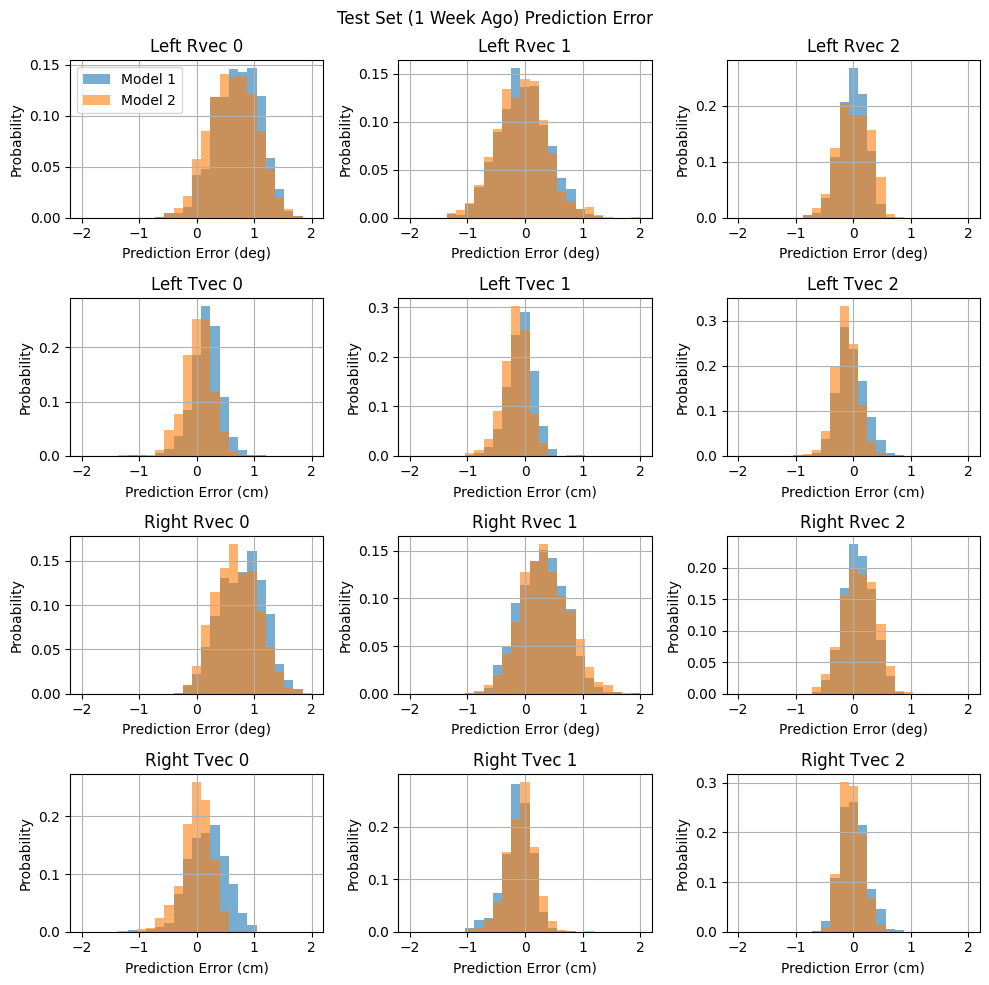

In [25]:
%matplotlib inline

# Initialize
data_list1 = [
    np.degrees(csv_df1['delta_l_rvec_0']),
    np.degrees(csv_df1['delta_l_rvec_1']),
    np.degrees(csv_df1['delta_l_rvec_2']),
    100*csv_df1['delta_l_tvec_0'],
    100*csv_df1['delta_l_tvec_1'],
    100*csv_df1['delta_l_tvec_2'],
    np.degrees(csv_df1['delta_r_rvec_0']),
    np.degrees(csv_df1['delta_r_rvec_1']),
    np.degrees(csv_df1['delta_r_rvec_2']),
    100*csv_df1['delta_r_tvec_0'],
    100*csv_df1['delta_r_tvec_1'],
    100*csv_df1['delta_r_tvec_2'],
]
data_list2 = [
    np.degrees(csv_df2['delta_l_rvec_0']),
    np.degrees(csv_df2['delta_l_rvec_1']),
    np.degrees(csv_df2['delta_l_rvec_2']),
    100*csv_df2['delta_l_tvec_0'],
    100*csv_df2['delta_l_tvec_1'],
    100*csv_df2['delta_l_tvec_2'],
    np.degrees(csv_df2['delta_r_rvec_0']),
    np.degrees(csv_df2['delta_r_rvec_1']),
    np.degrees(csv_df2['delta_r_rvec_2']),
    100*csv_df2['delta_r_tvec_0'],
    100*csv_df2['delta_r_tvec_1'],
    100*csv_df2['delta_r_tvec_2'],
]


hist_label_list = ['Left Rvec 0','Left Rvec 1','Left Rvec 2','Left Tvec 0','Left Tvec 1','Left Tvec 2',
             'Right Rvec 0','Right Rvec 1','Right Rvec 2','Right Tvec 0','Right Tvec 1','Right Tvec 2',]
x_label_list = ['Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',
               'Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',]

# Create a figure and a 2x6 grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(10,10))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Create histograms for each subplot
for i in range(12):
    sns.histplot(data_list1[i], bins=25, ax=axs[i], stat='probability', kde=False, alpha=0.6, binrange=(-2,2), edgecolor=None, label='Model 1')
    sns.histplot(data_list2[i], bins=25, ax=axs[i], stat='probability', kde=False, alpha=0.6, binrange=(-2,2), edgecolor=None, label='Model 2')
    axs[i].set_title(hist_label_list[i])
    axs[i].set_xlabel(x_label_list[i])
    axs[i].set_ylabel('Probability')
    axs[i].grid()
axs[0].legend()

# Adjust layout to prevent overlap
plt.suptitle('Test Set (1 Week Ago) Prediction Error')
plt.tight_layout()

In [26]:
results_idx = ['r(deg)','p(deg)', 'y(deg)', 'x(cm)','y(cm)', 'z(cm)',]
results_df = pd.DataFrame({'Model 1 Left Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df1['target_l_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df1['target_l_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df1['target_l_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_l_tvec_0'].values),torch.Tensor(100*csv_df1['target_l_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_l_tvec_1'].values),torch.Tensor(100*csv_df1['target_l_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_l_tvec_2'].values),torch.Tensor(100*csv_df1['target_l_tvec_2'].values)).cpu().item()),
                            ],
                          'Model 1 Right Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df1['target_r_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df1['target_r_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df1['target_r_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_r_tvec_0'].values),torch.Tensor(100*csv_df1['target_r_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_r_tvec_1'].values),torch.Tensor(100*csv_df1['target_r_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_r_tvec_2'].values),torch.Tensor(100*csv_df1['target_r_tvec_2'].values)).cpu().item()),
                          ],
                          'Model 2 Left Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df2['target_l_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df2['target_l_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df2['target_l_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_l_tvec_0'].values),torch.Tensor(100*csv_df2['target_l_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_l_tvec_1'].values),torch.Tensor(100*csv_df2['target_l_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_l_tvec_2'].values),torch.Tensor(100*csv_df2['target_l_tvec_2'].values)).cpu().item()),
                            ],
                          'Model 2 Right Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df2['target_r_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df2['target_r_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df2['target_r_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_r_tvec_0'].values),torch.Tensor(100*csv_df2['target_r_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_r_tvec_1'].values),torch.Tensor(100*csv_df2['target_r_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_r_tvec_2'].values),torch.Tensor(100*csv_df2['target_r_tvec_2'].values)).cpu().item()),
                            ],
                          })
results_df.index = results_idx
results_df

,Model 1 Left Eye RMSE,Model 1 Right Eye RMSE,Model 2 Left Eye RMSE,Model 2 Right Eye RMSE
r(deg),0.814848,0.872169,0.743767,0.784097
p(deg),0.430687,0.503746,0.449746,0.555505
y(deg),0.230405,0.266250,0.275537,0.302121
x(cm),0.301886,0.376008,0.250661,0.264658
y(cm),0.239610,0.285565,0.277772,0.267526
z(cm),0.237292,0.220768,0.237117,0.189465


# Train Comparison with Similar Commands

In [27]:
dataset_fn_new = "/home/jaynieles/dev/grace_dl/data/thesis/241010_best_075m_grace_dataset_1000.csv"
dataset_fn_og = "/home/jaynieles/dev/grace_dl/data/thesis/241003_075m_grace_dataset.csv"
ckpt_path1 = '/home/jaynieles/dev/grace_dl/logs/sfk/multiruns/2024-10-25_05-08-29/0/checkpoints/epoch_166.ckpt'

In [28]:
model1 = GraceLitModule.load_from_checkpoint(ckpt_path1)
new_all_df,_,_,_,scaled_new_all_df,_,_,_ = preprocess_csv(dataset_fn_new)
og_all_df,_,_,_,scaled_og_all_df,_,_,_ = preprocess_csv(dataset_fn_og)

/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [29]:
# Getting the Similar Commands
row_list = []
for j in range(len(new_all_df)):
    cmd_lnt_t = new_all_df['cmd_lnt_t'][j]
    cmd_lnp_t = new_all_df['cmd_lnp_t'][j]
    cmd_unt_t = new_all_df['cmd_unt_t'][j]
    cmd_et_t = new_all_df['cmd_et_t'][j]
    cmd_lep_t = new_all_df['cmd_lep_t'][j]
    row = og_all_df[(og_all_df['cmd_lnt_t']==cmd_lnt_t)
         & (og_all_df['cmd_lnp_t']==cmd_lnp_t)
         & (og_all_df['cmd_unt_t']==cmd_unt_t)
         & (og_all_df['cmd_et_t']==cmd_et_t)
         & (og_all_df['cmd_lep_t']==cmd_lep_t)]
    row_list.append(row)
    
og_filt_df = pd.concat(row_list)
scaled_og_filt_df = scaled_og_all_df.iloc[og_filt_df.index,:]
og_filt_df

,cmd_lnt_t,cmd_lnp_t,cmd_unt_t,cmd_et_t,cmd_lep_t,cmd_rep_t,l_rvec_0,l_rvec_1,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
42698,10,-10,20,-20,-4,-4,-0.016488,0.334989,-0.001933,0.010971,0.221288,-0.022826,-0.045150,0.013000,0.017331,-0.048121,0.217827,-0.031655
11176,30,5,-10,5,-4,-4,0.252021,0.108249,0.020842,-0.016387,0.173468,-0.004854,0.217169,-0.198501,0.084092,-0.084290,0.168157,-0.021888
4887,0,35,-10,-20,-4,-4,0.184975,-0.324121,0.034214,-0.069200,0.198030,-0.003668,0.163406,-0.640084,0.092457,-0.127411,0.196316,-0.040111
4892,0,35,-10,-20,6,6,0.187356,-0.588799,0.067745,-0.071924,0.198633,-0.023586,0.160949,-0.922208,0.133952,-0.116827,0.195938,-0.079092
51861,0,-25,30,-20,-8,-8,-0.189813,0.686205,-0.034709,0.030678,0.244028,-0.056030,-0.209908,0.371070,-0.046997,-0.017569,0.240990,-0.049273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28386,0,0,10,-30,14,14,0.066664,-0.258459,0.051771,-0.025164,0.215862,-0.001965,0.036249,-0.604492,0.096377,-0.082803,0.213570,-0.052736
19978,20,-30,0,-25,10,10,0.296173,0.301911,-0.023032,0.047680,0.188896,0.029209,0.261245,-0.022423,0.049548,-0.032174,0.187656,0.007528
19914,20,-30,0,-5,2,2,0.150274,0.510634,-0.088235,0.050726,0.193369,-0.012915,0.130265,0.182773,-0.043717,-0.008764,0.193696,-0.012967
19851,20,-30,0,15,-4,-4,0.017283,0.664319,-0.123175,0.046425,0.196471,-0.046387,0.003188,0.332084,-0.100626,0.000668,0.192853,-0.035699


In [30]:
# Tensor Set
X_new = torch.tensor(scaled_new_all_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_new = torch.tensor(scaled_new_all_df.iloc[:,6:].values, dtype=torch.float32, device=device)
X_og = torch.tensor(scaled_og_filt_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_og = torch.tensor(scaled_og_filt_df.iloc[:,6:].values, dtype=torch.float32, device=device)

In [31]:
# Model 1 Evaluation
model1.eval()
with torch.no_grad():
    preds1 = model1(X_og)
    
# Organizing Results for analysis
inputs_arr = X_og.detach().cpu().numpy()
preds_arr1 = preds1.detach().cpu().numpy()
targets_arr = y_og.detach().cpu().numpy()

# Reorganizing DataFrame
data_df1 = pd.DataFrame({
    'cmd_lnt_t': MAX_DEG_VALUE*inputs_arr[:,0],
    'cmd_lnp_t': MAX_DEG_VALUE*inputs_arr[:,1],
    'cmd_unt_t': MAX_DEG_VALUE*inputs_arr[:,2],
    'cmd_et_t': MAX_DEG_VALUE*inputs_arr[:,3],
    'cmd_lep_t': MAX_DEG_VALUE*inputs_arr[:,4],
    'cmd_rep_t': MAX_DEG_VALUE*inputs_arr[:,5],

    'target_l_rvec_0': MAX_RVEC_VALUE*targets_arr[:,0],
    'target_l_rvec_1': MAX_RVEC_VALUE*targets_arr[:,1],
    'target_l_rvec_2': MAX_RVEC_VALUE*targets_arr[:,2],
    'target_l_tvec_0': MAX_METER_VALUE*targets_arr[:,3],
    'target_l_tvec_1': MAX_METER_VALUE*targets_arr[:,4],
    'target_l_tvec_2': MAX_METER_VALUE*targets_arr[:,5],
    'target_r_rvec_0': MAX_RVEC_VALUE*targets_arr[:,6],
    'target_r_rvec_1': MAX_RVEC_VALUE*targets_arr[:,7],
    'target_r_rvec_2': MAX_RVEC_VALUE*targets_arr[:,8],
    'target_r_tvec_0': MAX_METER_VALUE*targets_arr[:,9],
    'target_r_tvec_1': MAX_METER_VALUE*targets_arr[:,10],
    'target_r_tvec_2': MAX_METER_VALUE*targets_arr[:,11],

    'pred_l_rvec_0': MAX_RVEC_VALUE*preds_arr1[:,0],
    'pred_l_rvec_1': MAX_RVEC_VALUE*preds_arr1[:,1],
    'pred_l_rvec_2': MAX_RVEC_VALUE*preds_arr1[:,2],
    'pred_l_tvec_0': MAX_METER_VALUE*preds_arr1[:,3],
    'pred_l_tvec_1': MAX_METER_VALUE*preds_arr1[:,4],
    'pred_l_tvec_2': MAX_METER_VALUE*preds_arr1[:,5],
    'pred_r_rvec_0': MAX_RVEC_VALUE*preds_arr1[:,6],
    'pred_r_rvec_1': MAX_RVEC_VALUE*preds_arr1[:,7],
    'pred_r_rvec_2': MAX_RVEC_VALUE*preds_arr1[:,8],
    'pred_r_tvec_0': MAX_METER_VALUE*preds_arr1[:,9],
    'pred_r_tvec_1': MAX_METER_VALUE*preds_arr1[:,10],
    'pred_r_tvec_2': MAX_METER_VALUE*preds_arr1[:,11],
})

# Delta Analysis
data_df1['delta_l_rvec_0'] = data_df1['target_l_rvec_0'].values - data_df1['pred_l_rvec_0'].values
data_df1['delta_l_rvec_1'] = data_df1['target_l_rvec_1'].values - data_df1['pred_l_rvec_1'].values
data_df1['delta_l_rvec_2'] = data_df1['target_l_rvec_2'].values - data_df1['pred_l_rvec_2'].values
data_df1['delta_l_tvec_0'] = data_df1['target_l_tvec_0'].values - data_df1['pred_l_tvec_0'].values
data_df1['delta_l_tvec_1'] = data_df1['target_l_tvec_1'].values - data_df1['pred_l_tvec_1'].values
data_df1['delta_l_tvec_2'] = data_df1['target_l_tvec_2'].values - data_df1['pred_l_tvec_2'].values
data_df1['delta_r_rvec_0'] = data_df1['target_r_rvec_0'].values - data_df1['pred_r_rvec_0'].values
data_df1['delta_r_rvec_1'] = data_df1['target_r_rvec_1'].values - data_df1['pred_r_rvec_1'].values
data_df1['delta_r_rvec_2'] = data_df1['target_r_rvec_2'].values - data_df1['pred_r_rvec_2'].values
data_df1['delta_r_tvec_0'] = data_df1['target_r_tvec_0'].values - data_df1['pred_r_tvec_0'].values
data_df1['delta_r_tvec_1'] = data_df1['target_r_tvec_1'].values - data_df1['pred_r_tvec_1'].values
data_df1['delta_r_tvec_2'] = data_df1['target_r_tvec_2'].values - data_df1['pred_r_tvec_2'].values

In [32]:
# Model 2 Evaluation
model1.eval()
with torch.no_grad():
    preds2 = model1(X_new)
    
# Organizing Results for analysis
inputs_arr = X_new.detach().cpu().numpy()
preds_arr2 = preds2.detach().cpu().numpy()
targets_arr = y_new.detach().cpu().numpy()

# Reorganizing DataFrame
data_df2 = pd.DataFrame({
    'cmd_lnt_t': MAX_DEG_VALUE*inputs_arr[:,0],
    'cmd_lnp_t': MAX_DEG_VALUE*inputs_arr[:,1],
    'cmd_unt_t': MAX_DEG_VALUE*inputs_arr[:,2],
    'cmd_et_t': MAX_DEG_VALUE*inputs_arr[:,3],
    'cmd_lep_t': MAX_DEG_VALUE*inputs_arr[:,4],
    'cmd_rep_t': MAX_DEG_VALUE*inputs_arr[:,5],

    'target_l_rvec_0': MAX_RVEC_VALUE*targets_arr[:,0],
    'target_l_rvec_1': MAX_RVEC_VALUE*targets_arr[:,1],
    'target_l_rvec_2': MAX_RVEC_VALUE*targets_arr[:,2],
    'target_l_tvec_0': MAX_METER_VALUE*targets_arr[:,3],
    'target_l_tvec_1': MAX_METER_VALUE*targets_arr[:,4],
    'target_l_tvec_2': MAX_METER_VALUE*targets_arr[:,5],
    'target_r_rvec_0': MAX_RVEC_VALUE*targets_arr[:,6],
    'target_r_rvec_1': MAX_RVEC_VALUE*targets_arr[:,7],
    'target_r_rvec_2': MAX_RVEC_VALUE*targets_arr[:,8],
    'target_r_tvec_0': MAX_METER_VALUE*targets_arr[:,9],
    'target_r_tvec_1': MAX_METER_VALUE*targets_arr[:,10],
    'target_r_tvec_2': MAX_METER_VALUE*targets_arr[:,11],

    'pred_l_rvec_0': MAX_RVEC_VALUE*preds_arr2[:,0],
    'pred_l_rvec_1': MAX_RVEC_VALUE*preds_arr2[:,1],
    'pred_l_rvec_2': MAX_RVEC_VALUE*preds_arr2[:,2],
    'pred_l_tvec_0': MAX_METER_VALUE*preds_arr2[:,3],
    'pred_l_tvec_1': MAX_METER_VALUE*preds_arr2[:,4],
    'pred_l_tvec_2': MAX_METER_VALUE*preds_arr2[:,5],
    'pred_r_rvec_0': MAX_RVEC_VALUE*preds_arr2[:,6],
    'pred_r_rvec_1': MAX_RVEC_VALUE*preds_arr2[:,7],
    'pred_r_rvec_2': MAX_RVEC_VALUE*preds_arr2[:,8],
    'pred_r_tvec_0': MAX_METER_VALUE*preds_arr2[:,9],
    'pred_r_tvec_1': MAX_METER_VALUE*preds_arr2[:,10],
    'pred_r_tvec_2': MAX_METER_VALUE*preds_arr2[:,11],
})

# Delta Analysis
data_df2['delta_l_rvec_0'] = data_df2['target_l_rvec_0'].values - data_df2['pred_l_rvec_0'].values
data_df2['delta_l_rvec_1'] = data_df2['target_l_rvec_1'].values - data_df2['pred_l_rvec_1'].values
data_df2['delta_l_rvec_2'] = data_df2['target_l_rvec_2'].values - data_df2['pred_l_rvec_2'].values
data_df2['delta_l_tvec_0'] = data_df2['target_l_tvec_0'].values - data_df2['pred_l_tvec_0'].values
data_df2['delta_l_tvec_1'] = data_df2['target_l_tvec_1'].values - data_df2['pred_l_tvec_1'].values
data_df2['delta_l_tvec_2'] = data_df2['target_l_tvec_2'].values - data_df2['pred_l_tvec_2'].values
data_df2['delta_r_rvec_0'] = data_df2['target_r_rvec_0'].values - data_df2['pred_r_rvec_0'].values
data_df2['delta_r_rvec_1'] = data_df2['target_r_rvec_1'].values - data_df2['pred_r_rvec_1'].values
data_df2['delta_r_rvec_2'] = data_df2['target_r_rvec_2'].values - data_df2['pred_r_rvec_2'].values
data_df2['delta_r_tvec_0'] = data_df2['target_r_tvec_0'].values - data_df2['pred_r_tvec_0'].values
data_df2['delta_r_tvec_1'] = data_df2['target_r_tvec_1'].values - data_df2['pred_r_tvec_1'].values
data_df2['delta_r_tvec_2'] = data_df2['target_r_tvec_2'].values - data_df2['pred_r_tvec_2'].values

In [33]:
csv_df1 = data_df1.copy()
csv_df2 = data_df2.copy()

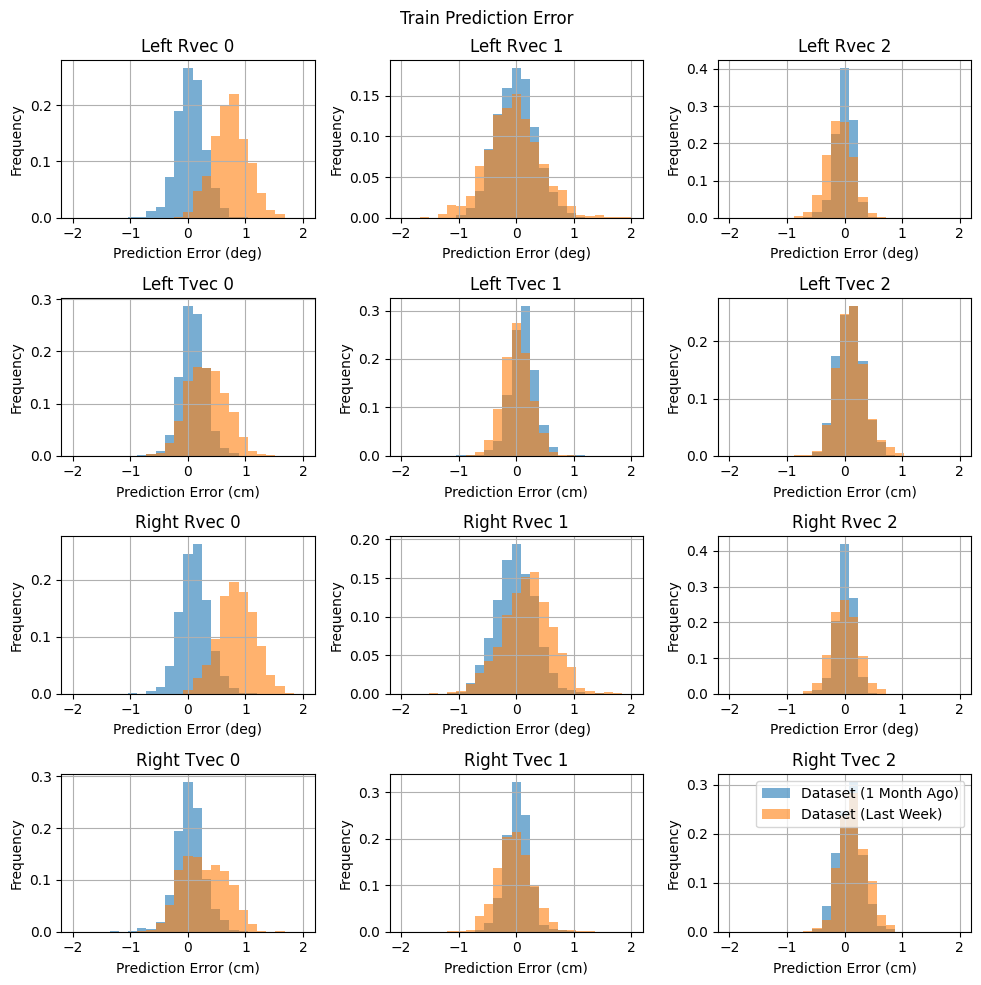

In [34]:
%matplotlib inline

# Initialize
data_list1 = [
    np.degrees(csv_df1['delta_l_rvec_0']),
    np.degrees(csv_df1['delta_l_rvec_1']),
    np.degrees(csv_df1['delta_l_rvec_2']),
    100*csv_df1['delta_l_tvec_0'],
    100*csv_df1['delta_l_tvec_1'],
    100*csv_df1['delta_l_tvec_2'],
    np.degrees(csv_df1['delta_r_rvec_0']),
    np.degrees(csv_df1['delta_r_rvec_1']),
    np.degrees(csv_df1['delta_r_rvec_2']),
    100*csv_df1['delta_r_tvec_0'],
    100*csv_df1['delta_r_tvec_1'],
    100*csv_df1['delta_r_tvec_2'],
]
data_list2 = [
    np.degrees(csv_df2['delta_l_rvec_0']),
    np.degrees(csv_df2['delta_l_rvec_1']),
    np.degrees(csv_df2['delta_l_rvec_2']),
    100*csv_df2['delta_l_tvec_0'],
    100*csv_df2['delta_l_tvec_1'],
    100*csv_df2['delta_l_tvec_2'],
    np.degrees(csv_df2['delta_r_rvec_0']),
    np.degrees(csv_df2['delta_r_rvec_1']),
    np.degrees(csv_df2['delta_r_rvec_2']),
    100*csv_df2['delta_r_tvec_0'],
    100*csv_df2['delta_r_tvec_1'],
    100*csv_df2['delta_r_tvec_2'],
]


hist_label_list = ['Left Rvec 0','Left Rvec 1','Left Rvec 2','Left Tvec 0','Left Tvec 1','Left Tvec 2',
             'Right Rvec 0','Right Rvec 1','Right Rvec 2','Right Tvec 0','Right Tvec 1','Right Tvec 2',]
x_label_list = ['Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',
               'Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',]

# Create a figure and a 2x6 grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(10,10))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Create histograms for each subplot
for i in range(12):
    sns.histplot(data_list1[i], bins=25, ax=axs[i], stat='probability', kde=False, alpha=0.6, binrange=(-2,2), edgecolor=None, label='Dataset (1 Month Ago)')
    sns.histplot(data_list2[i], bins=25, ax=axs[i], stat='probability', kde=False, alpha=0.6, binrange=(-2,2), edgecolor=None, label='Dataset (Last Week)')
    axs[i].set_title(hist_label_list[i])
    axs[i].set_xlabel(x_label_list[i])
    axs[i].set_ylabel('Frequency')
    axs[i].grid()
axs[-1].legend()

# Adjust layout to prevent overlap
plt.suptitle('Train Prediction Error')
plt.tight_layout()

In [35]:
results_idx = ['r(deg)','p(deg)', 'y(deg)', 'x(cm)','y(cm)', 'z(cm)',]
results_df = pd.DataFrame({'Dataset (1 Month Ago) Left Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df1['target_l_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df1['target_l_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df1['target_l_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_l_tvec_0'].values),torch.Tensor(100*csv_df1['target_l_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_l_tvec_1'].values),torch.Tensor(100*csv_df1['target_l_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_l_tvec_2'].values),torch.Tensor(100*csv_df1['target_l_tvec_2'].values)).cpu().item()),
                            ],
                          'Dataset (1 Month Ago) Right Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df1['target_r_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df1['target_r_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df1['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df1['target_r_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_r_tvec_0'].values),torch.Tensor(100*csv_df1['target_r_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_r_tvec_1'].values),torch.Tensor(100*csv_df1['target_r_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df1['pred_r_tvec_2'].values),torch.Tensor(100*csv_df1['target_r_tvec_2'].values)).cpu().item()),
                          ],
                          'Dataset (Last Week) Left Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df2['target_l_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df2['target_l_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df2['target_l_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_l_tvec_0'].values),torch.Tensor(100*csv_df2['target_l_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_l_tvec_1'].values),torch.Tensor(100*csv_df2['target_l_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_l_tvec_2'].values),torch.Tensor(100*csv_df2['target_l_tvec_2'].values)).cpu().item()),
                            ],
                          'Dataset (Last Week) Right Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df2['target_r_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df2['target_r_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df2['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df2['target_r_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_r_tvec_0'].values),torch.Tensor(100*csv_df2['target_r_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_r_tvec_1'].values),torch.Tensor(100*csv_df2['target_r_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df2['pred_r_tvec_2'].values),torch.Tensor(100*csv_df2['target_r_tvec_2'].values)).cpu().item()),
                            ],
                          })
results_df.index = results_idx
results_df

,Dataset (1 Month Ago) Left Eye RMSE,Dataset (1 Month Ago) Right Eye RMSE,Dataset (Last Week) Left Eye RMSE,Dataset (Last Week) Right Eye RMSE
r(deg),0.249625,0.273184,0.794030,0.899291
p(deg),0.342345,0.339413,0.481523,0.466993
y(deg),0.156915,0.150746,0.241558,0.227919
x(cm),0.232934,0.249541,0.468372,0.477394
y(cm),0.243645,0.204290,0.239737,0.305595
z(cm),0.242990,0.233826,0.269158,0.278651


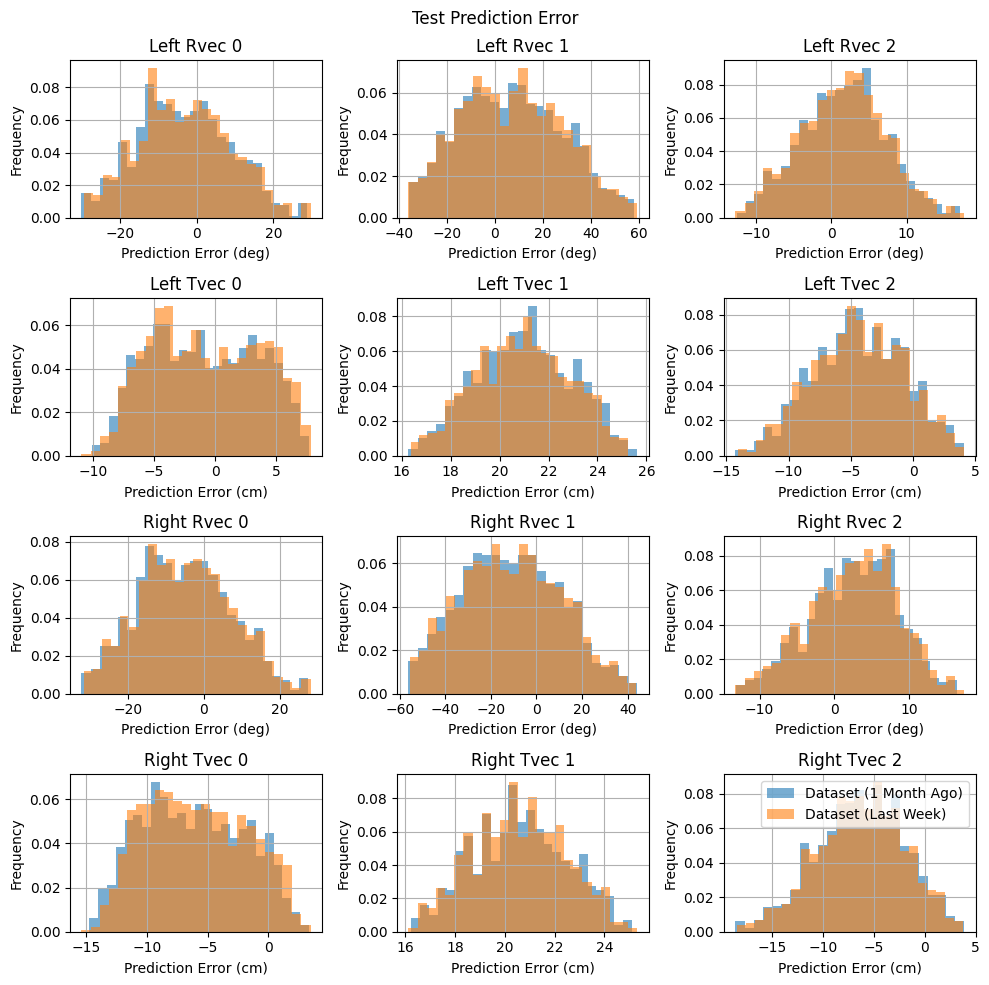

In [36]:
%matplotlib inline

# Initialize
data_list1 = [
    np.degrees(csv_df1['target_l_rvec_0']),
    np.degrees(csv_df1['target_l_rvec_1']),
    np.degrees(csv_df1['target_l_rvec_2']),
    100*csv_df1['target_l_tvec_0'],
    100*csv_df1['target_l_tvec_1'],
    100*csv_df1['target_l_tvec_2'],
    np.degrees(csv_df1['target_r_rvec_0']),
    np.degrees(csv_df1['target_r_rvec_1']),
    np.degrees(csv_df1['target_r_rvec_2']),
    100*csv_df1['target_r_tvec_0'],
    100*csv_df1['target_r_tvec_1'],
    100*csv_df1['target_r_tvec_2'],
]
data_list2 = [
    np.degrees(csv_df2['target_l_rvec_0']),
    np.degrees(csv_df2['target_l_rvec_1']),
    np.degrees(csv_df2['target_l_rvec_2']),
    100*csv_df2['target_l_tvec_0'],
    100*csv_df2['target_l_tvec_1'],
    100*csv_df2['target_l_tvec_2'],
    np.degrees(csv_df2['target_r_rvec_0']),
    np.degrees(csv_df2['target_r_rvec_1']),
    np.degrees(csv_df2['target_r_rvec_2']),
    100*csv_df2['target_r_tvec_0'],
    100*csv_df2['target_r_tvec_1'],
    100*csv_df2['target_r_tvec_2'],
]


hist_label_list = ['Left Rvec 0','Left Rvec 1','Left Rvec 2','Left Tvec 0','Left Tvec 1','Left Tvec 2',
             'Right Rvec 0','Right Rvec 1','Right Rvec 2','Right Tvec 0','Right Tvec 1','Right Tvec 2',]
x_label_list = ['Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',
               'Prediction Error (deg)','Prediction Error (deg)','Prediction Error (deg)','Prediction Error (cm)','Prediction Error (cm)','Prediction Error (cm)',]

# Create a figure and a 2x6 grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(10,10))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Create histograms for each subplot
for i in range(12):
    sns.histplot(data_list1[i], bins=25, ax=axs[i], stat='probability', kde=False, alpha=0.6, edgecolor=None, label='Dataset (1 Month Ago)')
    sns.histplot(data_list2[i], bins=25, ax=axs[i], stat='probability', kde=False, alpha=0.6, edgecolor=None, label='Dataset (Last Week)')
    axs[i].set_title(hist_label_list[i])
    axs[i].set_xlabel(x_label_list[i])
    axs[i].set_ylabel('Frequency')
    axs[i].grid()
axs[-1].legend()

# Adjust layout to prevent overlap
plt.suptitle('Test Prediction Error')
plt.tight_layout()

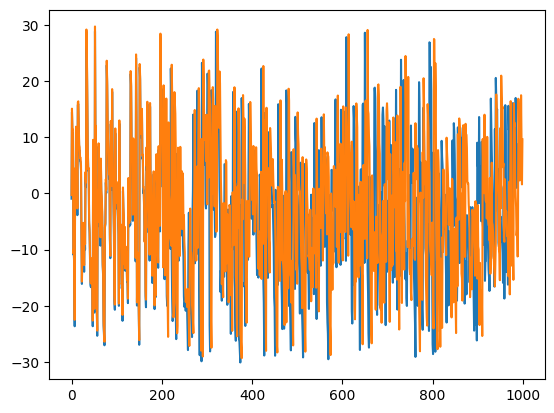

In [37]:
plt.figure()
plt.plot(np.degrees(csv_df1['target_l_rvec_0']))
plt.plot(np.degrees(csv_df2['target_l_rvec_0']))

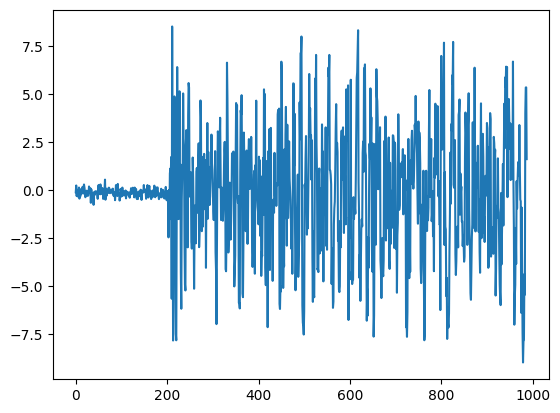

In [38]:
plt.figure()
plt.plot(np.degrees(csv_df1['target_r_tvec_0'])-np.degrees(csv_df2['target_r_tvec_0']))

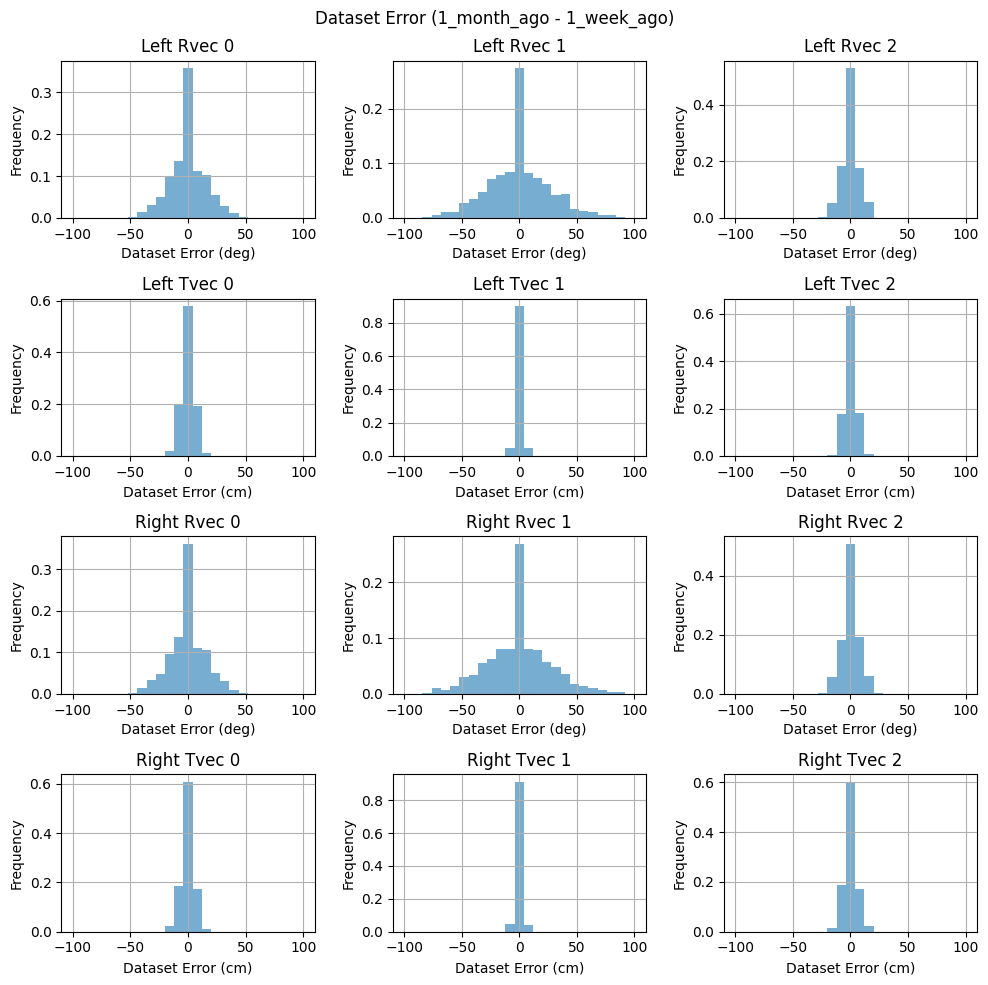

In [39]:
%matplotlib inline

# Initialize
data_list1 = [
    np.degrees(csv_df1['target_l_rvec_0'])-np.degrees(csv_df2['target_l_rvec_0']),
    np.degrees(csv_df1['target_l_rvec_1'])-np.degrees(csv_df2['target_l_rvec_1']),
    np.degrees(csv_df1['target_l_rvec_2'])-np.degrees(csv_df2['target_l_rvec_2']),
    100*csv_df1['target_l_tvec_0']-100*csv_df2['target_l_tvec_0'],
    100*csv_df1['target_l_tvec_1']-100*csv_df2['target_l_tvec_1'],
    100*csv_df1['target_l_tvec_2']-100*csv_df2['target_l_tvec_2'],
    np.degrees(csv_df1['target_r_rvec_0'])-np.degrees(csv_df2['target_r_rvec_0']),
    np.degrees(csv_df1['target_r_rvec_1'])-np.degrees(csv_df2['target_r_rvec_1']),
    np.degrees(csv_df1['target_r_rvec_2'])-np.degrees(csv_df2['target_r_rvec_2']),
    100*csv_df1['target_r_tvec_0']-100*csv_df2['target_r_tvec_0'],
    100*csv_df1['target_r_tvec_1']-100*csv_df2['target_r_tvec_1'],
    100*csv_df1['target_r_tvec_2']-100*csv_df2['target_r_tvec_2'],
]


hist_label_list = ['Left Rvec 0','Left Rvec 1','Left Rvec 2','Left Tvec 0','Left Tvec 1','Left Tvec 2',
             'Right Rvec 0','Right Rvec 1','Right Rvec 2','Right Tvec 0','Right Tvec 1','Right Tvec 2',]
x_label_list = ['Dataset Error (deg)','Dataset Error (deg)','Dataset Error (deg)','Dataset Error (cm)','Dataset Error (cm)','Dataset Error (cm)',
               'Dataset Error (deg)','Dataset Error (deg)','Dataset Error (deg)','Dataset Error (cm)','Dataset Error (cm)','Dataset Error (cm)',]

# Create a figure and a 2x6 grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(10,10))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Create histograms for each subplot
for i in range(12):
    sns.histplot(data_list1[i], bins=25, ax=axs[i], stat='probability', kde=False, alpha=0.6, binrange=(-100,100), edgecolor=None, label='Dataset (1 Month Ago)')
    axs[i].set_title(hist_label_list[i])
    axs[i].set_xlabel(x_label_list[i])
    axs[i].set_ylabel('Frequency')
    axs[i].grid()

# Adjust layout to prevent overlap
plt.suptitle('Dataset Error (1_month_ago - 1_week_ago)')
plt.tight_layout()

In [40]:
og_filt_df

,cmd_lnt_t,cmd_lnp_t,cmd_unt_t,cmd_et_t,cmd_lep_t,cmd_rep_t,l_rvec_0,l_rvec_1,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
42698,10,-10,20,-20,-4,-4,-0.016488,0.334989,-0.001933,0.010971,0.221288,-0.022826,-0.045150,0.013000,0.017331,-0.048121,0.217827,-0.031655
11176,30,5,-10,5,-4,-4,0.252021,0.108249,0.020842,-0.016387,0.173468,-0.004854,0.217169,-0.198501,0.084092,-0.084290,0.168157,-0.021888
4887,0,35,-10,-20,-4,-4,0.184975,-0.324121,0.034214,-0.069200,0.198030,-0.003668,0.163406,-0.640084,0.092457,-0.127411,0.196316,-0.040111
4892,0,35,-10,-20,6,6,0.187356,-0.588799,0.067745,-0.071924,0.198633,-0.023586,0.160949,-0.922208,0.133952,-0.116827,0.195938,-0.079092
51861,0,-25,30,-20,-8,-8,-0.189813,0.686205,-0.034709,0.030678,0.244028,-0.056030,-0.209908,0.371070,-0.046997,-0.017569,0.240990,-0.049273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28386,0,0,10,-30,14,14,0.066664,-0.258459,0.051771,-0.025164,0.215862,-0.001965,0.036249,-0.604492,0.096377,-0.082803,0.213570,-0.052736
19978,20,-30,0,-25,10,10,0.296173,0.301911,-0.023032,0.047680,0.188896,0.029209,0.261245,-0.022423,0.049548,-0.032174,0.187656,0.007528
19914,20,-30,0,-5,2,2,0.150274,0.510634,-0.088235,0.050726,0.193369,-0.012915,0.130265,0.182773,-0.043717,-0.008764,0.193696,-0.012967
19851,20,-30,0,15,-4,-4,0.017283,0.664319,-0.123175,0.046425,0.196471,-0.046387,0.003188,0.332084,-0.100626,0.000668,0.192853,-0.035699


In [41]:
new_all_df

,cmd_lnt_t,cmd_lnp_t,cmd_unt_t,cmd_et_t,cmd_lep_t,cmd_rep_t,l_rvec_0,l_rvec_1,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
0,10,-10,20,-20,-4,-4,-0.005022,0.330627,-0.001834,0.013952,0.220880,-0.022894,-0.036151,0.016754,0.018359,-0.046222,0.215155,-0.033002
1,30,5,-10,5,-4,-4,0.262980,0.111149,0.021784,-0.016891,0.171790,-0.005735,0.227169,-0.183613,0.086227,-0.088528,0.165655,-0.019555
2,0,35,-10,-20,-4,-4,0.195558,-0.325143,0.033210,-0.067773,0.195365,-0.003188,0.175724,-0.639191,0.092169,-0.122014,0.194930,-0.038908
3,0,35,-10,-20,6,6,0.198701,-0.585882,0.066531,-0.065690,0.197204,-0.022729,0.174122,-0.909756,0.133289,-0.116739,0.195208,-0.076890
4,0,-25,30,-20,-8,-8,-0.185813,0.678520,-0.038095,0.035495,0.239372,-0.057691,-0.204720,0.375033,-0.048869,-0.014758,0.237287,-0.049759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,10,-30,14,14,0.077139,-0.256867,0.049382,-0.026079,0.214806,-0.000563,0.048834,-0.608994,0.094548,-0.076444,0.214147,-0.051313
996,20,-30,0,-25,10,10,0.304704,0.309729,-0.024370,0.049232,0.187875,0.027643,0.270502,-0.011454,0.049442,-0.031717,0.186309,0.007618
997,20,-30,0,-5,2,2,0.157461,0.509572,-0.089290,0.056724,0.190668,-0.013074,0.139348,0.198098,-0.043332,-0.012698,0.192864,-0.014111
998,20,-30,0,15,-4,-4,0.027909,0.654448,-0.126870,0.053056,0.193488,-0.047282,0.013865,0.337612,-0.103511,0.003073,0.190800,-0.036063


In [ ]:
dataset_fn = "/home/jaynieles/dev/grace_dl/data/thesis/241010_best_075m_grace_dataset_1000.csv"
all_df,train_df,val_df,test_df,scaled_all_df,scaled_train_df,scaled_val_df,scaled_test_df = preprocess_csv(dataset_fn)

In [ ]:
# Input
idx = 100

# Left Camera
pred_l_rvec = np.array([data_df['pred_l_rvec_0'][idx],data_df['pred_l_rvec_1'][idx],data_df['pred_l_rvec_2'][idx]])
pred_l_tvec = np.array([data_df['pred_l_tvec_0'][idx],data_df['pred_l_tvec_1'][idx],data_df['pred_l_tvec_2'][idx]])
target_l_rvec =  np.array([data_df['target_l_rvec_0'][idx],data_df['target_l_rvec_1'][idx],data_df['target_l_rvec_2'][idx]])
target_l_tvec = np.array([data_df['target_l_tvec_0'][idx],data_df['target_l_tvec_1'][idx],data_df['target_l_tvec_2'][idx]])
pred_l_homo = vec2homo(pred_l_rvec, pred_l_tvec)
target_l_homo = vec2homo(target_l_rvec, target_l_tvec)
pred_l_homo_inv = np.linalg.inv(pred_l_homo)
target_l_homo_inv = np.linalg.inv(target_l_homo)

# Right Camera
pred_r_rvec = np.array([data_df['pred_r_rvec_0'][idx],data_df['pred_r_rvec_1'][idx],data_df['pred_r_rvec_2'][idx]])
pred_r_tvec = np.array([data_df['pred_r_tvec_0'][idx],data_df['pred_r_tvec_1'][idx],data_df['pred_r_tvec_2'][idx]])
target_r_rvec =  np.array([data_df['target_r_rvec_0'][idx],data_df['target_r_rvec_1'][idx],data_df['target_r_rvec_2'][idx]])
target_r_tvec = np.array([data_df['target_r_tvec_0'][idx],data_df['target_r_tvec_1'][idx],data_df['target_r_tvec_2'][idx]])
pred_r_homo = vec2homo(pred_r_rvec, pred_r_tvec)
target_r_homo = vec2homo(target_r_rvec, target_r_tvec)
pred_r_homo_inv = np.linalg.inv(pred_r_homo)
target_r_homo_inv = np.linalg.inv(target_r_homo)

print('Pred Left Cam:', pred_l_homo)
print('Target Left Cam:', target_l_homo)
print('Pred Right Cam:', pred_r_homo)
print('Target Right Cam:', target_r_homo)

In [ ]:
%matplotlib widget

# Plot
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = pr.plot_basis()

# Left Camera
ax = pr.plot_basis(R=pred_l_homo_inv[:3,:3], p=pred_l_homo_inv[:3,3].flatten())
ax = pr.plot_basis(R=target_l_homo_inv[:3,:3], p=target_l_homo_inv[:3,3].flatten())

# Right Camera
ax = pr.plot_basis(R=pred_r_homo_inv[:3,:3], p=pred_r_homo_inv[:3,3].flatten())
ax = pr.plot_basis(R=target_r_homo_inv[:3,:3], p=target_r_homo_inv[:3,3].flatten())

ax.view_init(elev=-70, azim=-90, roll=0)
ax.set_title('Left and Right Eye')
plt.tight_layout()